In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motion classification with time series using deep learning

> Classify between chaotic, rotational and librational motion using the evolution of the coordinates x and y in the Poincare map

## Requirements

In [ ]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    !pip install git+https://github.com/fastai/fastcore.git@master -q
    !pip install git+https://github.com/fastai/fastai2.git@master -q
    !pip install git+https://github.com/ai-fast-track/timeseries.git -q
    !pip install wandb -q

In [ ]:
from fastai.basics import *
from tsai.all import * # Used form models, and possibly pre-processing
from timeseries.all import * # Used for dataloaders 
from mlchaos.all import *
import wandb
from fastai.callback.wandb import *

In [ ]:
base_path = Path.home()/'rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos'
ds_path = base_path/'fli_rotnum/model_1'

## Notebook parameters 
Put here everything that could be needed if this notebook was called from outside, as an script

In [ ]:
use_wandb = False # Whether to use or not wandb for experiment tracking
wandb_group = None # Whether to group this run in a wandb group
resampling_period = 4 # * Natural number. Set to None if no resampling is desired
labelling_method = 'birav' # [fli, fli_no_uncertainty, freq_ana, birkhoff_avg, ...]
multiindex_handler = None # None (default), random, uncertainty. Only if labelling method = combined
val_dataset = 'eps=0.023' # * The rest of the datasets in fnames will be used for training
fnames_poinc_map = [ds_path/'eps=0.021/Poincare.plt', 
                    ds_path/'eps=0.022/Poincare.plt', 
                    ds_path/'eps=0.023/Poincare.plt',
                    ds_path/'eps=0.024/Poincare.plt', 
                    ds_path/'eps=0.025/Poincare.plt']
fnames_index = [ds_path/'eps=0.021/index_fli_rotnum_birav_birrefined_v3.plt', 
               ds_path/'eps=0.022/index_fli_rotnum_birav_birrefined_v3.plt',
               ds_path/'eps=0.023/index_fli_rotnum_birav_birrefined_v3.plt',
               ds_path/'eps=0.024/index_fli_rotnum_birav_birrefined_v3.plt',
               ds_path/'eps=0.025/index_fli_rotnum_birav_birrefined_v3.plt']

## Syncing with Weights & Biases

For large experiments, when this notebooks is called from outside with different parameters, it is important to use wandb to track the results and config of this notebook and to track and aggregate the results online afterwards.

In [ ]:
wandb.init(mode='online' if use_wandb else 'disabled', 
           entity='vrodriguezf', project='mlchaos', group=wandb_group, 
           allow_val_change=True)

## Loading the data

The data must be loaded as a `TSDataChaos` object, created from a pair (or a sequence of pairs) of files:
1. The first file of the pair contains the data of the Poincare map
2. The second file of the pair contains the index of the motion (0.0, 1.0 or 2.0). The column that contains the index is given as a parameter of this notebook

Depending on the labelling method, a different column from the index file will be used as `y` on the data. `x` will always be the time series.

In [ ]:
wandb.config.fnames_poinc_map = fnames_poinc_map
wandb.config.fnames_index = fnames_index

In [ ]:
fnames = L(fnames_poinc_map).zipwith(fnames_index)

In [ ]:
wandb.config.labelling_method = ifnone(wandb.config.get('labelling_method'), labelling_method)
index_cols = {
    "fli": 4,
    "fli_no_uncertainty": 5,
    "freq_ana_eq_3.5": 6,
    "freq_ana_eq_3.6": 7,
    "birav": 8,
    "birav_refined": 9,
    "combined": list(range(4,9)) # Exclude the birav refined from the combined since it has different classes
}

In [ ]:
wandb.config.fnames = fnames
wandb.config.multiindex_handler = multiindex_handler
data = TSDataChaos.from_poincare_and_index_files(fnames, 
                                                 index_col=index_cols[wandb.config.labelling_method], 
                                                 multiindex_handler=multiindex_handler)
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.021', 'eps=0.022', 'eps=0.023', 'eps=0.024', 'eps=0.025']
 Filenames:                     [(Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.021/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.021/index_fli_rotnum_birav_birrefined_v3.plt')), (Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.022/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.022/index_fli_rotnum_birav_birrefined_v3.plt')), (Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/index_fli_rotnum_birav_birrefined_v3.

Check the distribution of classes in the dataset

In [ ]:
np.unique(data.y, return_counts=True)

(array([-1.,  0.,  1.,  2.]), array([  201,  5218, 25899, 19687]))

The class -1 represents uncertainty in the FLI-based classication. If desired, we can remove that class from the dataset, by changing the flag `add_uncertainty_class` in the cell below. 

In [ ]:
wandb.config.add_uncertainty_class = False

In [ ]:
# TODO: Move this to a function
if not wandb.config.add_uncertainty_class:
    data.remove_uncertainty()
wandb.config.nb_samples = data.get_nb_samples()
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.021', 'eps=0.022', 'eps=0.023', 'eps=0.024', 'eps=0.025']
 Filenames:                     [(Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.021/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.021/index_fli_rotnum_birav_birrefined_v3.plt')), (Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.022/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.022/index_fli_rotnum_birav_birrefined_v3.plt')), (Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/index_fli_rotnum_birav_birrefined_v3.

The data can be resampled to a lower frequency if desired. The reason why this is interesting is because being able to produce an accurate classification without the need of many data points per time series makes this procedure applicable to observational data. As an example, choosing `resampling_period` equals to 2 means that the time series will be resampled in a way that we take one point every 2 points of the original data.  

In [ ]:
wandb.config.resampling_period = resampling_period

In [ ]:
if wandb.config.resampling_period is not None:
    data.x = data.x[:,:,::wandb.config.resampling_period]
    print(data)

TSDataChaos:
 Datasets names (concatenated): ['eps=0.021', 'eps=0.022', 'eps=0.023', 'eps=0.024', 'eps=0.025']
 Filenames:                     [(Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.021/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.021/index_fli_rotnum_birav_birrefined_v3.plt')), (Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.022/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.022/index_fli_rotnum_birav_birrefined_v3.plt')), (Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/index_fli_rotnum_birav_birrefined_v3.

We'll use a dictionary to establish how to label each index to an actual human-readable label

In [ ]:
if wandb.config.labelling_method == "birav_refined":
    lbl_dict = dict([
        ('-1.0', 'uncertain'),        
        ('0.0', 'librational_0.00'),
        ('0.25', 'librational_0.25'),
        ('0.33', 'librational_0.33'),
        ('0.5', 'librational_0.50'),
        ('0.66', 'librational_0.66'),
        ('0.75', 'librational_0.75'),
        ('1.0', 'librational_1.00'),
        ('5.0', 'chaotic'),
        ('6.0', 'nonrotational')
    ])
else:    
    lbl_dict = dict([
        ('-1.0', 'uncertain'),
        ('0.0', 'chaotic'),   
        ('1.0', 'rotational'),   
        ('2.0', 'librational')]
    )

## Splitting the data into training and validation

One easy option to split data is to use 80% random items from the data as training and 20% as validation

In [ ]:
splits = RandomSplitter()(range_of(data.get_items()))
#splits = (range_of(data.get_items()), range_of(data.get_items())) # Valid = train

Another way to split the data, which is more sensible if we want to ensure that the knowledge in the model can be transferred to unknown dynamic models, is to ensure that motions in the validation set are not included in the training set. We can do this by ensuring that the motions of the validation set belong to a specific dynamic model, and the rest of dynamics will be used for training

In [ ]:
wandb.config.val_ds = ifnone(wandb.config.get('val_ds'), val_dataset)

In [ ]:
val_idxs = np.where(data.ds == data.dsname.index(wandb.config.val_ds))[0]
val_idxs

array([20336, 20337, 20338, ..., 30498, 30499, 30500])

In [ ]:
splits = IndexSplitter(val_idxs)(data.get_items())
splits

((#40639) [0,1,2,3,4,5,6,7,8,9...],
 (#10165) [20336,20337,20338,20339,20340,20341,20342,20343,20344,20345...])

##  Creating a `Datasets` object

In [ ]:
tfms = [[ItemGetter(0), ToTensorTS(), ToTensorMotion()], # x transforms
        [ItemGetter(1), lbl_dict.get, Categorize()]] # y transforms

In [ ]:
ds = Datasets(items=data.get_items(), tfms=tfms, splits=splits)

In [ ]:
wandb.config['ds.train.__len__()'] = ds.train.__len__()
wandb.config['ds.valid.__len__()'] = ds.valid.__len__()

Show one element of the dataset. By default, the `show` method will display the item as a Poincare map.

rotational


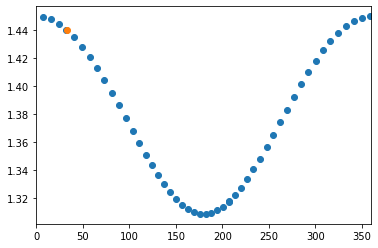

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1))

It can be useful to visualize the motions with he same y limits. We take them from the training set

In [ ]:
ylim = [data.x[:, 1].min(), data.x[:, 1].max()]
ylim

[-0.621059207764438, 1.62105920776477]

rotational


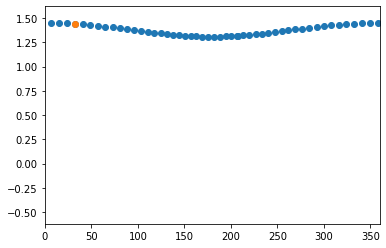

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1), ylim=ylim)

## Creating a `Dataloaders` object

In [ ]:
bs = 512                            
# Normalize at batch time
tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [] # TSStandardize()

dls = ds.dataloaders(bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

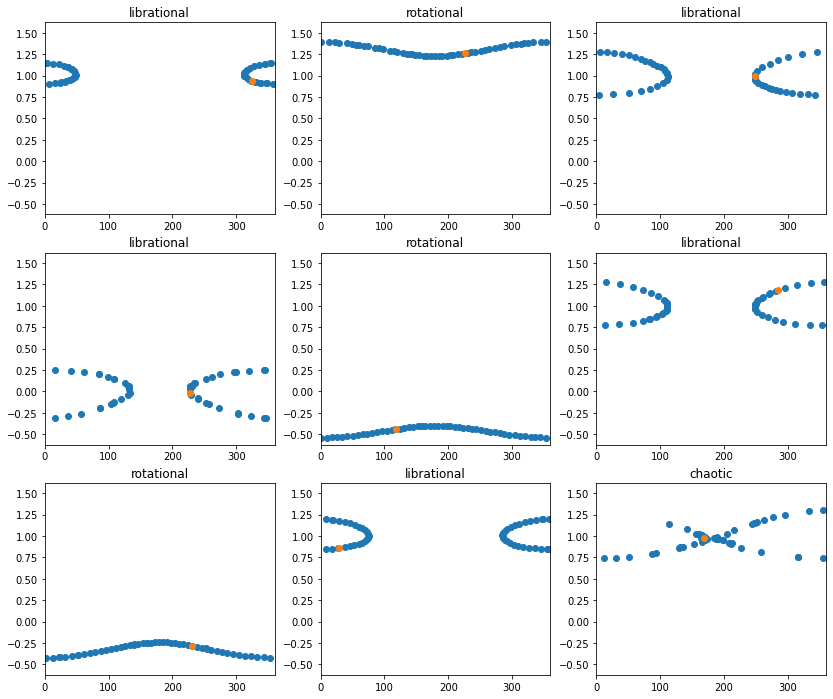

In [ ]:
dls.show_batch(max_n=9, ylim=ylim, return_fig=False)

In [ ]:
xb, yb = dls.one_batch()
print(xb[0].mean(axis=1), xb[0].std(axis=1))

TensorMotion([180.5402,   0.3120], device='cuda:0') TensorMotion([9.4875e+01, 2.7566e-02], device='cuda:0')


## Training a model 

In [ ]:
c_in = data.n_channels
c_out= dls.c #Number of classes
seq_len = data.x.shape[-1]
c_in, c_out, seq_len

(2, 3, 51)

Choose the architecture of the model. Optionally change the default hyperaparameters.
See all the available architectures at https://timeseriesai.github.io/tsai/

In [ ]:
wandb.config.arch_name = ifnone(wandb.config.get('arch_name'), 'XCM')
arch = eval(wandb.config.arch_name) 
args = {} # default to {}

In [ ]:
model = create_model(arch, c_in, c_out, seq_len, **args)

### Creating a Learner object

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner    
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)
# print(learn.summary())

In [ ]:
beep(1)

(0.05248074531555176, 0.007585775572806597)

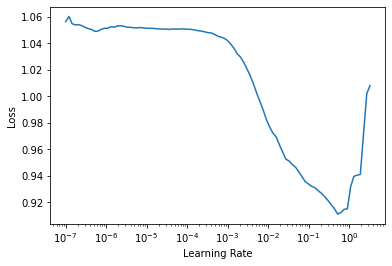

In [ ]:
lr_min, lr_steep = learn.lr_find()
log_plt_as_wandb_img('LR curve')
lr_min, lr_steep

epoch,train_loss,valid_loss,accuracy,time
0,0.823002,0.676424,0.781702,00:53
1,0.607830,0.892197,0.515789,00:53
2,0.491571,0.821861,0.833350,00:53
3,0.423565,2.673335,0.545106,00:53
4,0.383066,0.551935,0.890703,00:53
5,0.361704,0.566557,0.835809,00:53
6,0.347982,0.656231,0.821348,00:53
7,0.338017,0.381796,0.958091,00:53
8,0.332451,0.339103,0.978652,00:53
9,0.328171,0.334079,0.981308,00:53


Better model found at epoch 0 with valid_loss value: 0.676423966884613.
Better model found at epoch 4 with valid_loss value: 0.5519351363182068.
Better model found at epoch 7 with valid_loss value: 0.3817959725856781.
Better model found at epoch 8 with valid_loss value: 0.3391033709049225.
Better model found at epoch 9 with valid_loss value: 0.334078848361969.


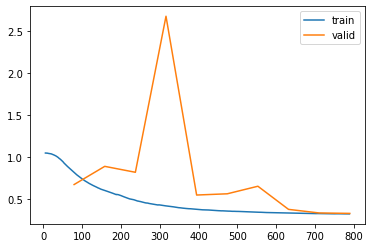

In [ ]:
learn.fit_one_cycle(10, lr_max=lr_steep, cbs=[SaveModelCallback(), 
                                              WandbCallback(log_preds=False)])
learn.recorder.plot_loss()

## Showing results

### Results for random items in the validation set 

In [ ]:
#amaps = [np.random.rand(data.x.shape[1], data.x.shape[2]) for _ in range(9)]

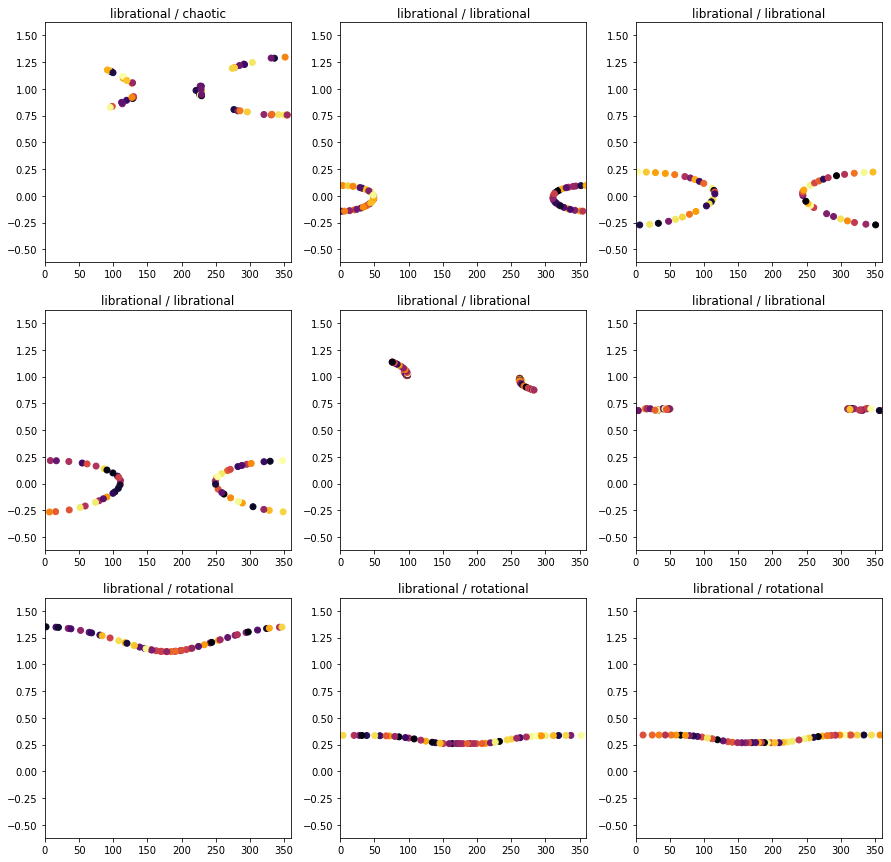

In [ ]:
learn.show_results(max_n=9, ylim=ylim, figsize=(15, 15))

### Confusion matrix

In [ ]:
interp = ClassificationInterpretationAugmented.from_learner(learn)

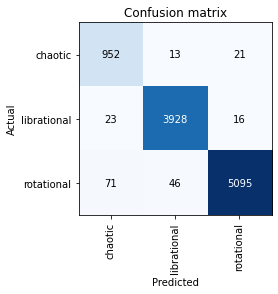

In [ ]:
interp.plot_confusion_matrix()
log_plt_as_wandb_img('confusion_matrix')

### Smallest errors

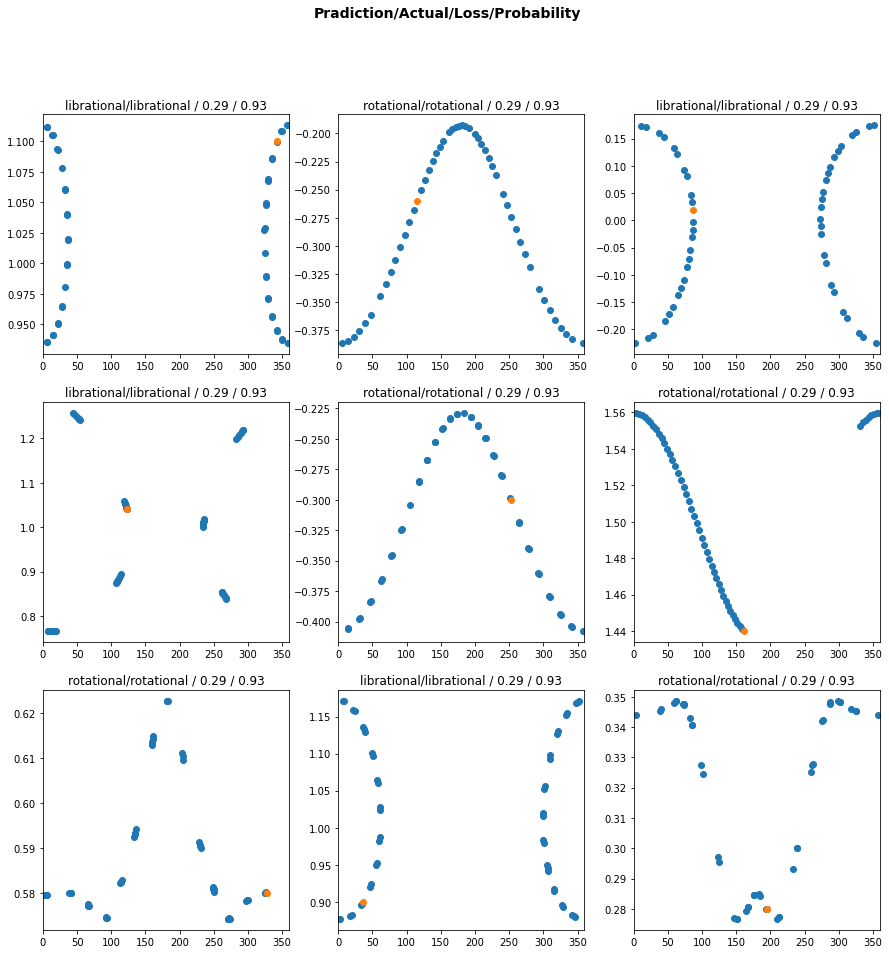

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=False)

### Largest errores

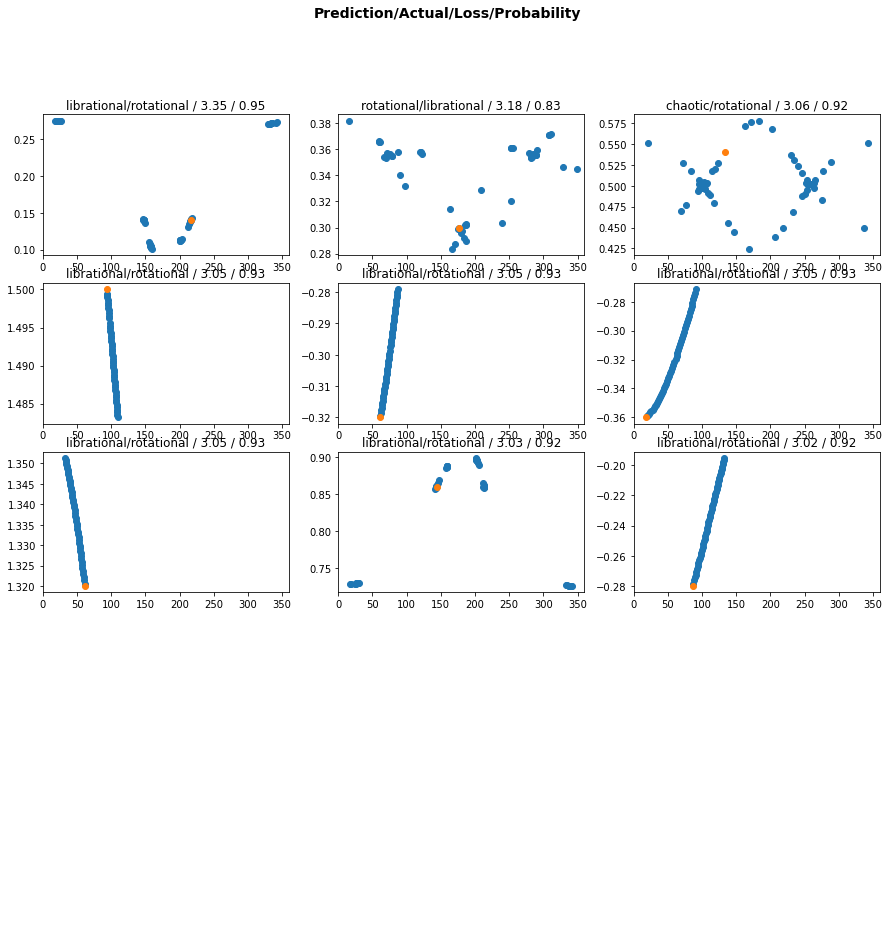

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), nrows=5, largest=True, ncols=3)
log_plt_as_wandb_img('largest_errors')

### Specific types of errors

It is also interesting to display separately errors of different type. There are a number of `c*(c-1)` possible type of errors, where `c` is the number of classes in the data

In [ ]:
print(interp.top_losses(k=3, largest=False, predicted='chaotic', actual='chaotic'))
print(interp.top_losses(k=3, largest=False, predicted='rotational', actual='rotational'))
print(interp.top_losses(k=3, largest=False, predicted='librational', actual='librational'))

(TensorCategory([0.3061, 0.3061, 0.3061]), TensorCategory([21788, 21786, 21785]))
(TensorCategory([0.2911, 0.2911, 0.2911]), TensorCategory([39864, 39863, 39862]))
(TensorCategory([0.2911, 0.2911, 0.2911]), TensorCategory([38227, 38226, 38225]))


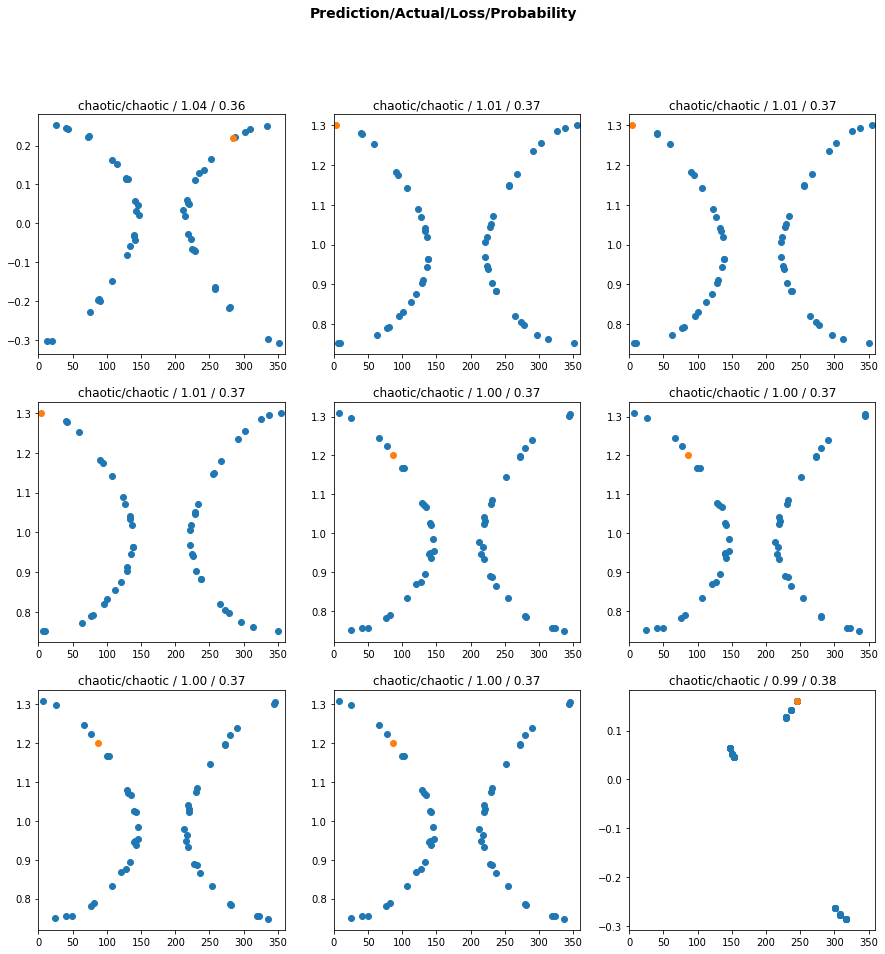

In [ ]:
predicted = 'chaotic'
actual = 'chaotic'
n_errors = interp.confusion_matrix()[interp.vocab.o2i[predicted], 
                                     interp.vocab.o2i[actual]]
interp.plot_top_losses(k=min(n_errors, 9), figsize=(15, 15), 
                       largest=True, 
                       predicted=predicted, 
                       actual=actual)

### Overview of the results through a labelled initial condition map

Show each motion in the validation set in a Poincare map showing just its initial point (x0, y0), coloured by the dynamical index associated to it. We will plot two figures, one with the dynamical index given by the ML model (predictions) and one with the true dynamic indices given by the `labelling_method`

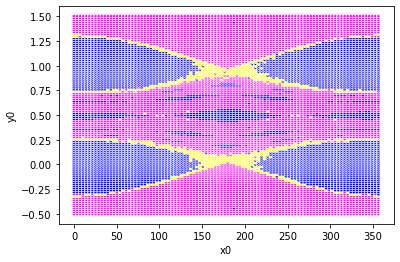

In [ ]:
ml_map = show_labelled_ic_map(interp.inputs, 
                    [dls.tfms[1].decode(y) for y in interp.decoded], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))
log_plt_as_wandb_img('ML map ({wandb.config.val_ds})')
# wandb.log({f'ML map ({wandb.config.val_ds})': ml_map.figure}) # Glitchy: https://github.com/mpld3/mpld3/issues/479

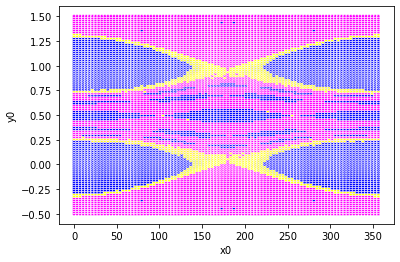

In [ ]:
true_map = show_labelled_ic_map(interp.inputs, 
                    [dls.tfms[1].decode(y) for y in interp.targs], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

#wandb.log({f'True map ({wandb.config.val_ds})': true_map.figure})

## Explaining the model predictions through class activation maps

Show the attribution map on top of the poincare map of a specific item. The attribution map maps every point in the poincare map with the importance it has in the prediction model. 

In [ ]:
module = model.conv1dblock #*
idxs = [6066, 4971, 3779] #*
y = None #*

In [ ]:
xb, _ = to_device(dls.do_batch(ds.valid[idxs]))
amap = get_attibution_map(model, module, x=xb, y=y, cpu=True)
xb.shape, xb.device, amap.shape, amap.device

(torch.Size([3, 2, 51]),
 device(type='cuda', index=0),
 torch.Size([3, 2, 51]),
 device(type='cpu'))

AssertionError: Wrong dimensions in attribution_map. torch.Size([3, 2, 51]), torch.Size([2, 51])

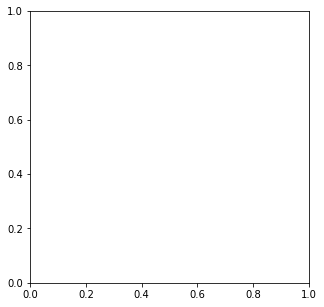

In [ ]:
interp.show_at(idxs, am=amap, figsize=(5,5))

## Inference on a new test set

Now let's see how the trained behaves with a completely unseen set of data. First we have to load the Poincare maps that comprise the test set

Compute the predicted labels using the library `fastinference`. It is faster than the original `fastai` implementation.

In [ ]:
#old_get_preds = learn.get_preds
#from fastinference.inference import *

In [ ]:
fnames_test = (ds_path/'eps=0.023/Poincare.plt',
               ds_path/'eps=0.023/index_fli_rotnum_birav_birrefined_v3.plt')
test_data = TSDataChaos.from_poincare_and_index_files(fnames_test, 
                                                      index_col=index_cols['birav'])
test_data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.023']
 Filenames:                     [(Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/index_fli_rotnum_birav_birrefined_v3.plt'))]
 Data shape: (10201, 2, 201)
 Targets shape: (10201,)
 Nb Samples: 10201
 Nb Channels:           2
 Sequence Length: 201

In [ ]:
if not wandb.config.add_uncertainty_class:
    test_data.remove_uncertainty()
test_data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.023']
 Filenames:                     [(Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/jupyterhub-homes/3063/rclone_local/gdrive/Universidad/Proyectos/2020/MLchaos/fli_rotnum/model_1/eps=0.023/index_fli_rotnum_birav_birrefined_v3.plt'))]
 Data shape: (10165, 2, 201)
 Targets shape: (10165,)
 Nb Samples: 10165
 Nb Channels:           2
 Sequence Length: 201

Create a dataloader from the test items previously loaded. This will apply all the transformations used in our training and validation set (e.g. normalization) to the test data

In [ ]:
test_dl = learn.dls.test_dl(test_data.get_items(), with_labels=True)
test_dl.n

10165

preds, targs, preds_decoded = learn.get_preds(dl=test_dl, with_decoded=True)
preds.__len__()

Compute metrics (validation loss and accuracy) on the test set.

In [ ]:
test_metrics = learn.validate(dl=test_dl)
test_metrics

(#2) [0.905390739440918,0.6030496954917908]

Show also trhe confusion matrix for this test set

# learn.get_preds = old_get_preds
interp_test = ClassificationInterpretationAugmented.from_learner(learn, 
                                                                 dl=test_dl)

interp_test.plot_confusion_matrix(
    title=f'Confusion matrix (accuracy={round(test_metrics[1], 2)})',
)
plt.savefig(test_base_path/f'confusion_matrix_{test_base_path.name}.png')

Show the FLI plot to get a sense of the quality of the predictions

ml_map = show_fli_plot(test_data.x, 
                    [dls.tfms[1].decode(y) for y in preds_decoded], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

ml_map.figure.savefig(test_base_path/f'ml_map_{test_base_path.name}.eps', 
                      transparent=True, format='.eps')

Now show the same plot for the true labels given by the FLI-based classification

true_map = show_fli_plot(test_data.x, 
                    [dls.tfms[1].decode(y) for y in targs], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

true_map.figure.savefig(test_base_path/f'true_map_{test_base_path.name}.eps', 
                        transparent=True, format='.eps')